In [3]:
from google.colab import files
uploaded = files.upload()

Saving World_SeaborneTrade_CLEAN.csv to World_SeaborneTrade_CLEAN.csv


In [4]:
import pandas as pd
df = pd.read_csv("World_SeaborneTrade_CLEAN.csv")
df.columns = df.columns.str.strip()

df = df[df['CargoType'].isin([10, 11, 12, 13])]

df = df[df['Economy Label'] == 'World']

df = df.dropna(subset=['Trade_million_tons'])

labels = df[['CargoType Label', 'Economy Label']].reset_index(drop=True)

features = ['Year', 'Economy', 'CargoType', 'Metric tons in thousands']
X = df[features]
y = df['Trade_million_tons']

In [5]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# --- Code to define missing variables (y_test, y_pred, X_test, label_encoders) ---
# Make a copy of the dataframe for processing
df_model = df.copy()

# Label Encoding for categorical features
label_encoders = {}
for col_to_encode in ['Economy Label', 'CargoType Label']:
    le = LabelEncoder()
    df_model[col_to_encode] = le.fit_transform(df_model[col_to_encode])
    label_encoders[col_to_encode] = le

# Define features (X) and target (y) for the model
# Assuming model features include encoded labels as used in X_test for plotting
X_for_modeling = df_model[
    ['Year', 'Economy', 'CargoType', 'Metric tons in thousands', 'Economy Label', 'CargoType Label']
]
y_for_modeling = df_model['Trade_million_tons']

# Split data into training and testing sets (time-based split, no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_for_modeling, y_for_modeling, test_size=0.2, shuffle=False, random_state=42
)

# Initialize and train the XGBoost Regressor model
model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.015,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.001,
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
# --- End of code to define missing variables ---

# Create a DataFrame for plotting actual vs. predicted values
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'CargoType Label': X_test['CargoType Label'],
    'Economy Label': X_test['Economy Label']
})

# Inverse transform the label encoded columns to get original labels for plotting
results['CargoType Label'] = label_encoders['CargoType Label'].inverse_transform(results['CargoType Label'])
results['Economy Label'] = label_encoders['Economy Label'].inverse_transform(results['Economy Label'])

fig = px.scatter(
    results.sample(n=300, random_state=42) if len(results) > 300 else results,
    x="Actual",
    y="Predicted",
    color="CargoType Label",
    hover_data=["Economy Label", "CargoType Label"],
    title="Actual vs Predicted Trade (Interactive View)"
)
fig.show()

In [6]:
df_clean = df.dropna(subset=['Trade_million_tons']).copy()

In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def train_xgboost_for_trade(
    df,
    cargo_type,
    start_year,
    end_year,
    split_year=2018
):
    print(f"\n🚢 Training XGBoost (TS) for Cargo: {cargo_type}")

    # -------------------------------------------------
    # 1) Filter & prepare time series
    # -------------------------------------------------
    data = df[
        (df["CargoType Label"] == cargo_type) &
        (df["Year"] >= start_year) &
        (df["Year"] <= end_year)
    ].copy()

    data = data.groupby("Year")["Trade_million_tons"].mean().reset_index()
    data = data.sort_values("Year")

    y = pd.Series(
        data["Trade_million_tons"].values,
        index=pd.to_datetime(data["Year"], format="%Y")
    ).asfreq("YS").interpolate("time")

    # -------------------------------------------------
    # 2) Log + Differencing  (🔥 التصحيح الحقيقي)
    # -------------------------------------------------
    y_log = np.log1p(y)
    y_diff = y_log.diff().dropna()

    # -------------------------------------------------
    # 3) Feature engineering on differenced series
    # -------------------------------------------------
    df_feat = pd.DataFrame({"y": y_diff})

    for lag in [1, 2, 3, 4]:
        df_feat[f"lag_{lag}"] = df_feat["y"].shift(lag)

    df_feat["roll_mean_3"] = df_feat["y"].shift(1).rolling(3).mean()
    df_feat["roll_std_3"]  = df_feat["y"].shift(1).rolling(3).std()

    crisis_years = [2008, 2009, 2010, 2020]
    df_feat["crisis_flag"] = df_feat.index.year.isin(crisis_years).astype(int)

    df_feat = df_feat.dropna()

    X = df_feat.drop(columns=["y"])
    y_target = df_feat["y"]

    # -------------------------------------------------
    # 4) Time-based split
    # -------------------------------------------------
    X_train = X[X.index.year <= split_year]
    X_test  = X[X.index.year > split_year]

    y_train = y_target.loc[X_train.index]
    y_test  = y_target.loc[X_test.index]

    # -------------------------------------------------
    # 5) XGBoost model
    # -------------------------------------------------
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=400,
        learning_rate=0.03,
        max_depth=2,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5,
        reg_lambda=10,
        random_state=42
    )

    model.fit(X_train, y_train)

    # -------------------------------------------------
    # 6) Predict (DIFFERENCES)
    # -------------------------------------------------
    y_train_diff_pred = model.predict(X_train)
    y_test_diff_pred  = model.predict(X_test)

    # -------------------------------------------------
    # 7) Reconstruct original series
    # -------------------------------------------------
    first_train_val = y_log.loc[X_train.index[0] - pd.DateOffset(years=1)]
    y_train_log_pred = pd.Series(
        first_train_val + np.cumsum(y_train_diff_pred),
        index=X_train.index
    )

    last_train_val = y_train_log_pred.iloc[-1]
    y_test_log_pred = pd.Series(
        last_train_val + np.cumsum(y_test_diff_pred),
        index=X_test.index
    )

    y_train_pred = np.expm1(y_train_log_pred)
    y_test_pred  = np.expm1(y_test_log_pred)

    y_train_actual = y.loc[X_train.index]
    y_test_actual  = y.loc[X_test.index]

    # -------------------------------------------------
    # 8) Metrics
    # -------------------------------------------------
    def pe(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    rmse_test  = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

    pe_train = pe(y_train_actual, y_train_pred)
    pe_test = pe(y_test_actual, y_test_pred)
    r2_train = r2_score(y_train_actual, y_train_pred)
    r2_test = r2_score(y_test_actual, y_test_pred)

    print("\n=== XGBoost Time Series Results (FIXED) ===")
    print(f"Train → RMSE: {rmse_train:.2f} | PE: {pe_train:.2f}% | R²: {r2_train:.3f}")
    print(f"Test  → RMSE: {rmse_test:.2f} | PE: {pe_test:.2f}% | R²: {r2_test:.3f}")

    # -------------------------------------------------
    # 9) Plot (now it WILL move)
    # -------------------------------------------------
    plt.figure(figsize=(14, 6))
    plt.plot(y_train_actual, label="Train Actual", color="blue")
    plt.plot(y_test_actual, label="Test Actual", color="orange")
    plt.plot(y_train_pred, "--", label="Train Pred", color="green")
    plt.plot(y_test_pred, "--", label="Test Pred", color="red")
    plt.title(f"{cargo_type} — XGBoost Time Series Forecast (Log-Diff)")
    plt.xlabel("Year")
    plt.ylabel("Trade (Million Tons)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "cargo_type": cargo_type,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "pe_train": pe_train,
        "pe_test": pe_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "model": model
    }


🚢 Training XGBoost (TS) for Cargo: Crude oil loaded

=== XGBoost Time Series Results (FIXED) ===
Train → RMSE: 103.94 | PE: 3.76% | R²: -0.785
Test  → RMSE: 148.17 | PE: 6.55% | R²: -3.763


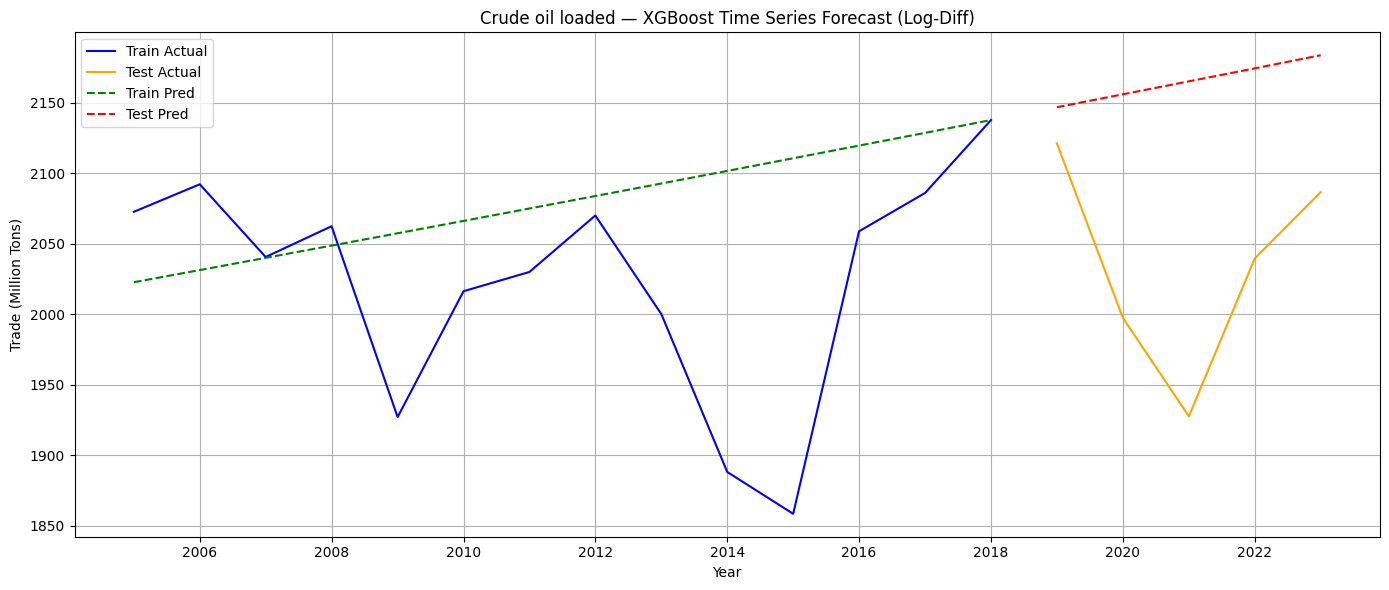

{'cargo_type': 'Crude oil loaded',
 'rmse_train': np.float64(103.94322678703381),
 'rmse_test': np.float64(148.17439518717921),
 'pe_train': np.float64(3.7591938731628396),
 'pe_test': np.float64(6.545142260422569),
 'r2_train': -0.7846971102371973,
 'r2_test': -3.76299364652514,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
          

In [23]:
train_xgboost_for_trade(
    df,
    cargo_type="Crude oil loaded",
    start_year=2000,
    end_year=2023
)


🚢 Training XGBoost (TS) for Cargo: Other tanker trade loaded

=== XGBoost Time Series Results (FIXED) ===
Train → RMSE: 106.61 | PE: 5.10% | R²: 0.738
Test  → RMSE: 145.77 | PE: 5.22% | R²: -7.221


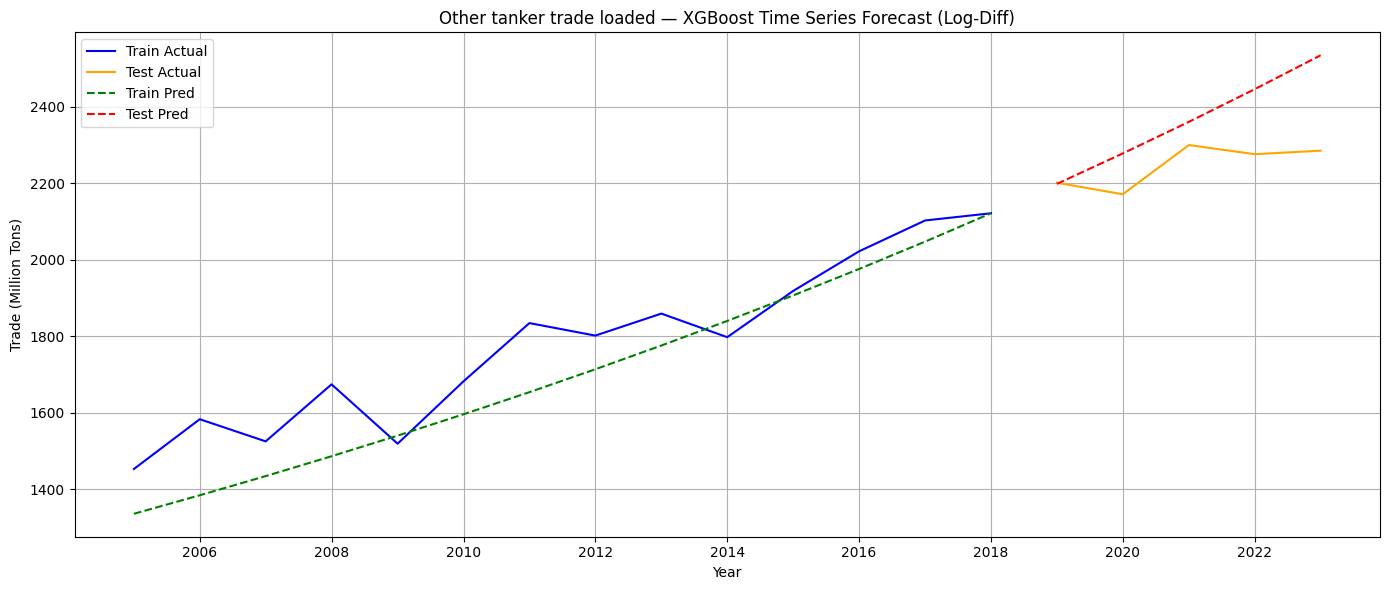

{'cargo_type': 'Other tanker trade loaded',
 'rmse_train': np.float64(106.61467070944578),
 'rmse_test': np.float64(145.77118515694886),
 'pe_train': np.float64(5.101648737750652),
 'pe_test': np.float64(5.216852272588995),
 'r2_train': 0.738231845191617,
 'r2_test': -7.221102419780243,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
   

In [24]:
train_xgboost_for_trade(
    df,
    cargo_type="Other tanker trade loaded",
    start_year=2000,
    end_year=2023
)


🚢 Training XGBoost (TS) for Cargo: Dry cargo loaded

=== XGBoost Time Series Results (FIXED) ===
Train → RMSE: 241.48 | PE: 3.76% | R²: 0.927
Test  → RMSE: 967.71 | PE: 12.14% | R²: -39.397


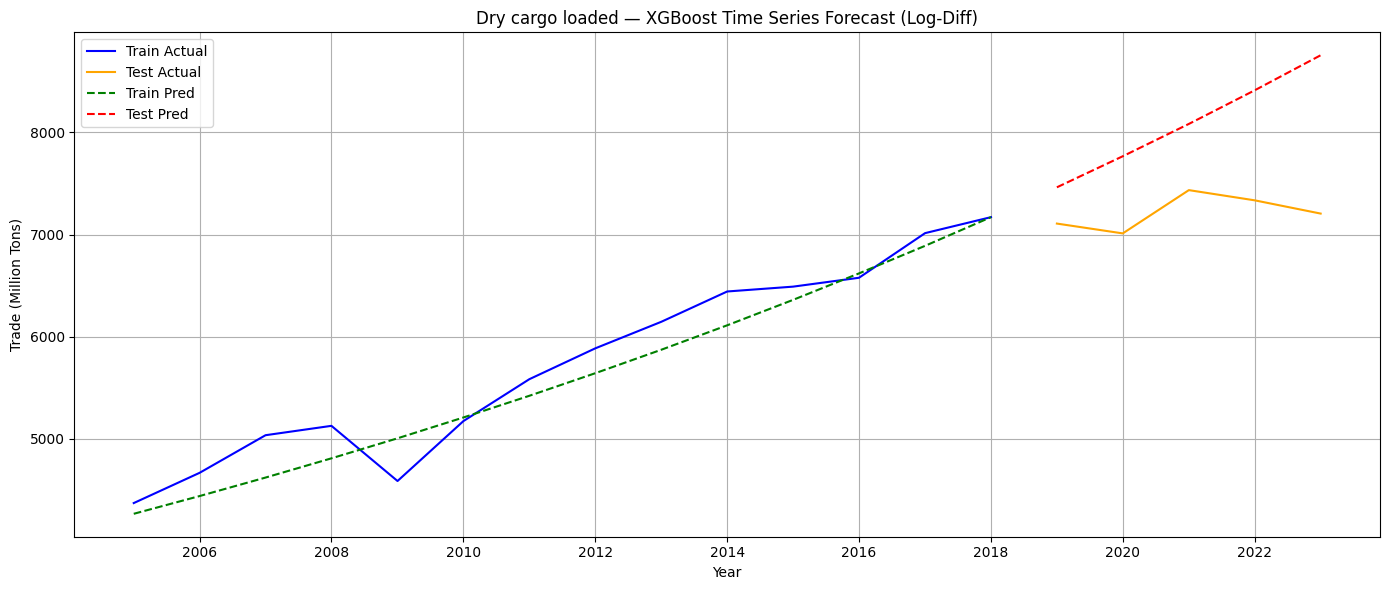

{'cargo_type': 'Dry cargo loaded',
 'rmse_train': np.float64(241.48138299636236),
 'rmse_test': np.float64(967.7142193804732),
 'pe_train': np.float64(3.7555980412640784),
 'pe_test': np.float64(12.13999711389383),
 'r2_train': 0.9270132017599657,
 'r2_test': -39.39743922283697,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
           

In [25]:
train_xgboost_for_trade(
    df,
    cargo_type="Dry cargo loaded",
    start_year=2000,
    end_year=2023
)


🚢 Training XGBoost (TS) for Cargo: Total goods loaded

=== XGBoost Time Series Results (FIXED) ===
Train → RMSE: 310.55 | PE: 2.80% | R²: 0.920
Test  → RMSE: 1155.11 | PE: 9.17% | R²: -40.098


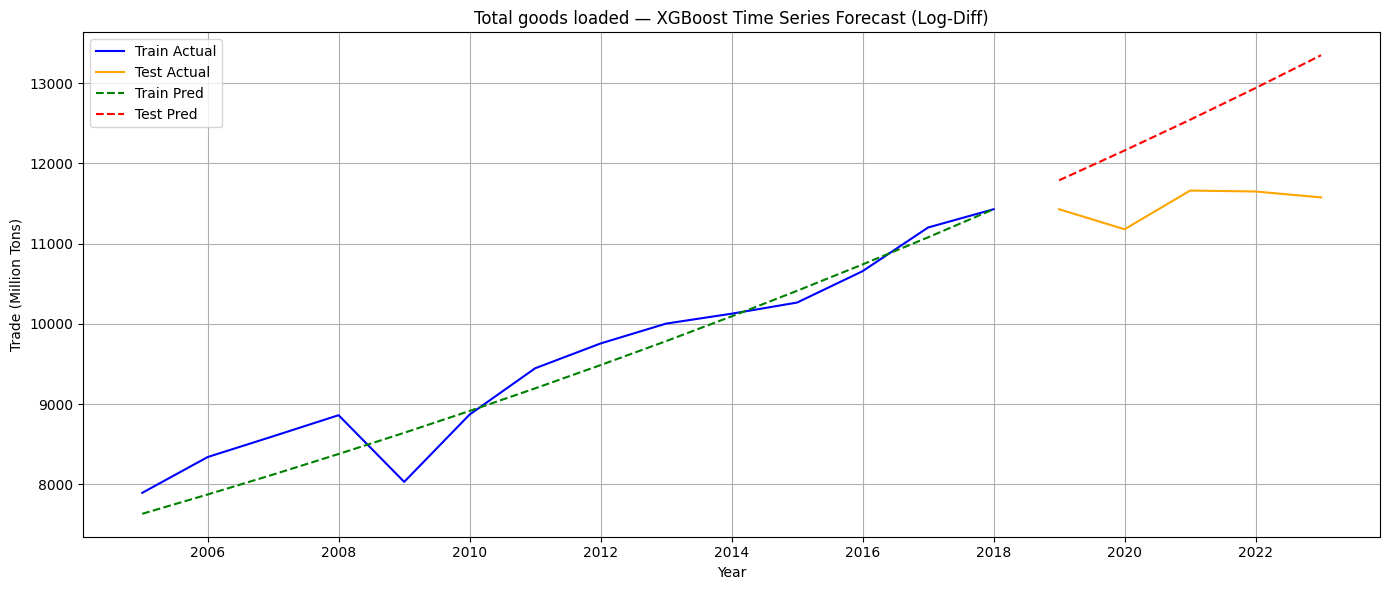

{'cargo_type': 'Total goods loaded',
 'rmse_train': np.float64(310.5456010174417),
 'rmse_test': np.float64(1155.1069032915293),
 'pe_train': np.float64(2.802704247143857),
 'pe_test': np.float64(9.172409832142218),
 'r2_train': 0.9202237252670542,
 'r2_test': -40.09818992098905,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
          

In [26]:
train_xgboost_for_trade(
    df,
    cargo_type="Total goods loaded",
    start_year=2000,
    end_year=2023
)